### Import

In [1]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.transform import resize
from skimage.filters import gabor
from skimage import data, io, filters, morphology, img_as_ubyte
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Getting the image paths

In [2]:
folders = os.listdir('../Datas/Ottawa-Dataset/')
if '.DS_Store' in folders:
	folders.remove('.DS_Store')
folders.sort()

image_paths = []
ground_truth_paths = []
for folder in folders:
	image_paths.append(f'../Datas/Ottawa-Dataset/{folder}/Ottawa-{folder}.tif')
	ground_truth_paths.append(f'../Datas/Ottawa-Dataset/{folder}/segmentation.png')

image_paths = sorted(image_paths, key=lambda x: int(re.search(r'(\d+)', x).group()))
ground_truth_paths = sorted(ground_truth_paths, key=lambda x: int(re.search(r'(\d+)', x).group()))

# print(image_paths)
# print(ground_truth_paths)

### Train-test split

In [3]:
# We use the first 15 images to train the model, and the last 4 to test it
test_size = 0.25
n_images = len(image_paths)
n_train = int(n_images * (1 - test_size))
# n_train = 15

train_image_paths = image_paths[:n_train]
train_label_paths = ground_truth_paths[:n_train]

test_image_paths = image_paths[n_train:]
test_label_paths = ground_truth_paths[n_train:]

# test_image_paths = train_image_paths
# test_label_paths = train_label_paths

### Functions to load the images and labels

In [ ]:
def white_balance_gray_world(image):
    result = image.copy()
    
    # Compute the mean of each channel
    mean_b = np.mean(image[:, :, 0])
    mean_g = np.mean(image[:, :, 1])
    mean_r = np.mean(image[:, :, 2])
    
    # Compute the adjustment factor
    mean_gray = (mean_b + mean_g + mean_r) / 3
    scale_b = mean_gray / mean_b
    scale_g = mean_gray / mean_g
    scale_r = mean_gray / mean_r

    # Apply correction to each channel
    result[:, :, 0] = np.clip(image[:, :, 0] * scale_b, 0, 255)
    result[:, :, 1] = np.clip(image[:, :, 1] * scale_g, 0, 255)
    result[:, :, 2] = np.clip(image[:, :, 2] * scale_r, 0, 255)

    return result.astype(np.uint8)


In [5]:
def improvements(image):
	#image = white_balance_gray_world(image)

	#print(image.shape)
	#print(image.shape[0] * image.shape[1])

	# nb_total_pixels = image.shape[0] * image.shape[1]
	# if nb_total_pixels < 1_000_000:
	# 	kernel_size = 1
	# else:
	# 	kernel_size = 7
	# image = cv2.medianBlur(image, kernel_size)

	return image

In [6]:
def read_satellite_image(image_path, scale_factor=1):
	#satellite_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
	satellite_image = Image.open(image_path)
	if satellite_image is None:
		raise ValueError(f"Error: {image_path}")
	
	satellite_image = np.where(np.isnan(satellite_image), 0, satellite_image)

	if len(satellite_image.shape) == 2:
		satellite_image = satellite_image[:, :, np.newaxis]
	# print(satellite_image.shape)

	new_width = satellite_image.shape[1] // scale_factor
	new_height = satellite_image.shape[0] // scale_factor
	satellite_image_resized = cv2.resize(satellite_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
	# print(satellite_image.shape)

	satellite_image_resized = improvements(satellite_image_resized)
	
	return satellite_image_resized

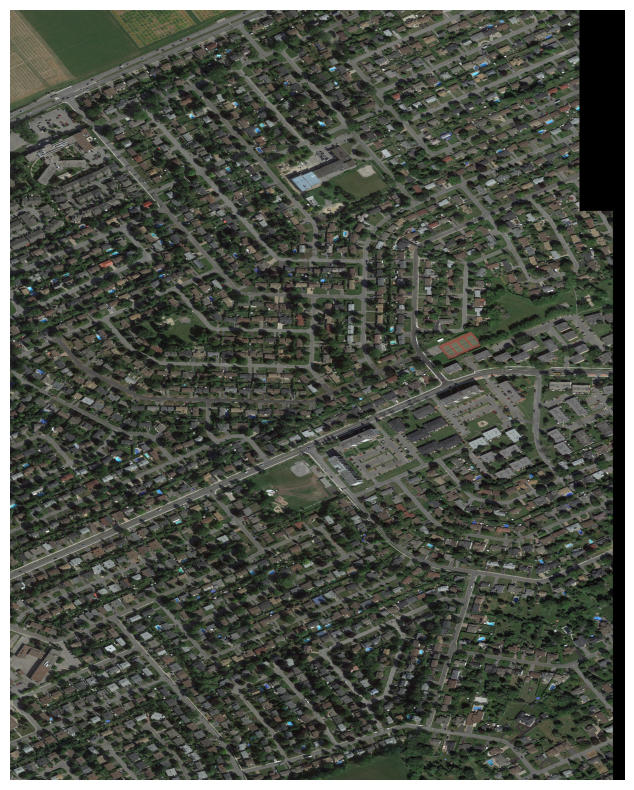

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(read_satellite_image(train_image_paths[0], 2))
plt.axis('off')
plt.show()

In [8]:
def read_ground_truth(ground_truth_path, scale_factor):
	#ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_UNCHANGED)
	ground_truth = Image.open(ground_truth_path)
	if ground_truth is None:
		raise ValueError(f"Error: {ground_truth_path}")
	
	ground_truth = np.where(np.isnan(ground_truth), 0, ground_truth)

	if len(ground_truth.shape) == 2:
		ground_truth = ground_truth[:, :, np.newaxis]
	# print(ground_truth.shape)

	new_width = ground_truth.shape[1] // scale_factor
	new_height = ground_truth.shape[0] // scale_factor
	ground_truth_resized = cv2.resize(ground_truth, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
	# print(ground_truth_resized.shape)

	green_channel = ground_truth_resized[..., 1]
	ground_truth_binary = (green_channel > 200).astype(np.uint8)

	return ground_truth_binary

### Train set

In [9]:
all_train_images = []
all_train_ground_truths = []
max_bands_train = 0

scale_factor = 6
for image_path, ground_truth_path in zip(train_image_paths, train_label_paths):
	satellite_image = read_satellite_image(image_path, scale_factor=scale_factor)
	ground_truth = read_ground_truth(ground_truth_path, scale_factor=scale_factor)

	if ground_truth.shape[0] != satellite_image.shape[0] or ground_truth.shape[1] != satellite_image.shape[1]:
		raise ValueError("Error")

	if satellite_image.shape[2] > max_bands_train:
		max_bands_train = satellite_image.shape[2]

	all_train_images.append(satellite_image)
	all_train_ground_truths.append(ground_truth)

for i in range(len(all_train_images)):
	satellite_image = all_train_images[i]
	nrow, ncol, nband = satellite_image.shape
	if nband < max_bands_train:
		diff = max_bands_train - nband
		extra_band = np.zeros((nrow, ncol, diff), dtype=satellite_image.dtype)
		satellite_image = np.concatenate((satellite_image, extra_band), axis=-1)
		all_train_images[i] = satellite_image

In [10]:
X_train_list = []
y_train_list = []
for satellite_image, ground_truth in zip(all_train_images, all_train_ground_truths):
	X_train_list.append(satellite_image.reshape(-1, max_bands_train))
	y_train_list.append(ground_truth.reshape(-1))

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("max_bands_train =", max_bands_train)

X_train: (3726822, 3)
y_train: (3726822,)
max_bands_train = 3


### Test set

In [ ]:
all_test_images = []
all_test_masks = []
max_bands_test = 0

for image_path, ground_truth_path in zip(test_image_paths, test_label_paths):
	satellite_image = read_satellite_image(image_path, scale_factor=scale_factor)
	ground_truth = read_ground_truth(ground_truth_path, scale_factor=scale_factor)

	if ground_truth.shape[0] != satellite_image.shape[0] or ground_truth.shape[1] != satellite_image.shape[1]:
		raise ValueError(f"Dimension mismatch between {img_path} and {gt_path} after resizing.")

	if satellite_image.shape[2] > max_bands_test:
		max_bands_test = satellite_image.shape[2]

	all_test_images.append(satellite_image)
	all_test_masks.append(ground_truth)

for i in range(len(all_test_images)):
	satellite_image = all_test_images[i]
	nrow, ncol, nband = satellite_image.shape
	if nband < max_bands_test:
		diff = max_bands_test - nband
		extra_band = np.zeros((nrow, ncol, diff), dtype=satellite_image.dtype)
		satellite_image = np.concatenate((satellite_image, extra_band), axis=-1)
		all_test_images[i] = satellite_image

In [12]:
nb_final_bands = max(max_bands_train, max_bands_test)

if max_bands_train < nb_final_bands:
	for i in range(len(all_train_images)):
		satellite_image = all_train_images[i]
		nrow, ncol, nband = satellite_image.shape
		diff = nb_final_bands - nband
		if diff > 0:
			extra_band = np.zeros((nrow, ncol, diff), dtype=satellite_image.dtype)
			satellite_image = np.concatenate((satellite_image, extra_band), axis=-1)
			all_train_images[i] = satellite_image

if max_bands_test < nb_final_bands:
	for i in range(len(all_test_images)):
		satellite_image = all_test_images[i]
		nrow, ncol, nband = satellite_image.shape
		diff = nb_final_bands - nband
		if diff > 0:
			extra_band = np.zeros((nrow, ncol, diff), dtype=satellite_image.dtype)
			satellite_image = np.concatenate((satellite_image, extra_band), axis=-1)
			all_test_images[i] = satellite_image

In [ ]:
X_test_list = []
y_test_list = []
test_shapes = []

for arr_img, mask in zip(all_test_images, all_test_masks):
	nrow, ncol, nband = arr_img.shape
	test_shapes.append((nrow, ncol))
	X_test_list.append(arr_img.reshape(-1, nb_final_bands))
	y_test_list.append(mask.reshape(-1))

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("Final number of bands:", nb_final_bands)

X_test: (1756502, 3)
y_test: (1756502,)
Nombre final de bandes : 3


### Model training

#### Random Forest

In [ ]:
# param_grid = {
#     'n_estimators': [10, 20, 50],  # Number of trees
#     'max_depth': [None, 10, 20],  # Maximum tree depth
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 5],  # Minimum number of samples per leaf
#     'criterion': ['gini', 'entropy']  # Splitting criterion
# }
# rf = RandomForestClassifier(n_jobs=-1, verbose=0)

# grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best validation score: {grid_search.best_score_:.4f}")

# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict(X_test)


rf = RandomForestClassifier(n_estimators=10, verbose=2, n_jobs=-1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.1s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished


RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=2)

#### DBScan

In [15]:
# dbscan = DBSCAN(eps=2, min_samples=10, n_jobs=-1)

#### SVM

In [16]:
# svm = SVC(kernel="rbf", C=1.0, gamma="scale", verbose=True)

# svm.fit(X_train, y_train)

#### XGBoost

In [17]:
# xgb = XGBClassifier(n_estimators=200, max_depth=60, learning_rate=0.1, verbosity=1, eval_metric="logloss")

# xgb.fit(X_train, y_train)

#### Mean Shift

In [18]:
# bandwidth = estimate_bandwidth(X_train, quantile=0.1, n_samples=5000)

# mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# mean_shift.fit(X_train)

### Prediction

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished


              precision    recall  f1-score   support

           0       0.64      0.49      0.55    230355
           1       0.93      0.96      0.94   1526147

    accuracy                           0.90   1756502
   macro avg       0.78      0.72      0.75   1756502
weighted avg       0.89      0.90      0.89   1756502



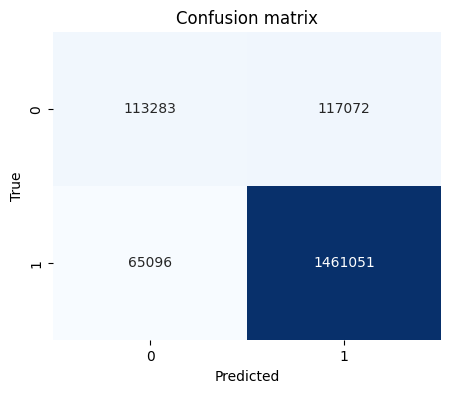

In [19]:
y_pred = rf.predict(X_test)

# y_pred = dbscan.fit_predict(X_test)
# y_pred = np.where(y_pred == -1, 0, 1)

# y_pred = svm.predict(X_test)

#y_pred = xgb.predict(X_test)

# y_pred = mean_shift.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()

### Plot

In [20]:
paths = image_paths[n_train:]
paths = [path[:-13] for path in paths]
print(paths)

['../Datas/Ottawa-Dataset/16/', '../Datas/Ottawa-Dataset/17/', '../Datas/Ottawa-Dataset/18/', '../Datas/Ottawa-Dataset/19/', '../Datas/Ottawa-Dataset/20/']


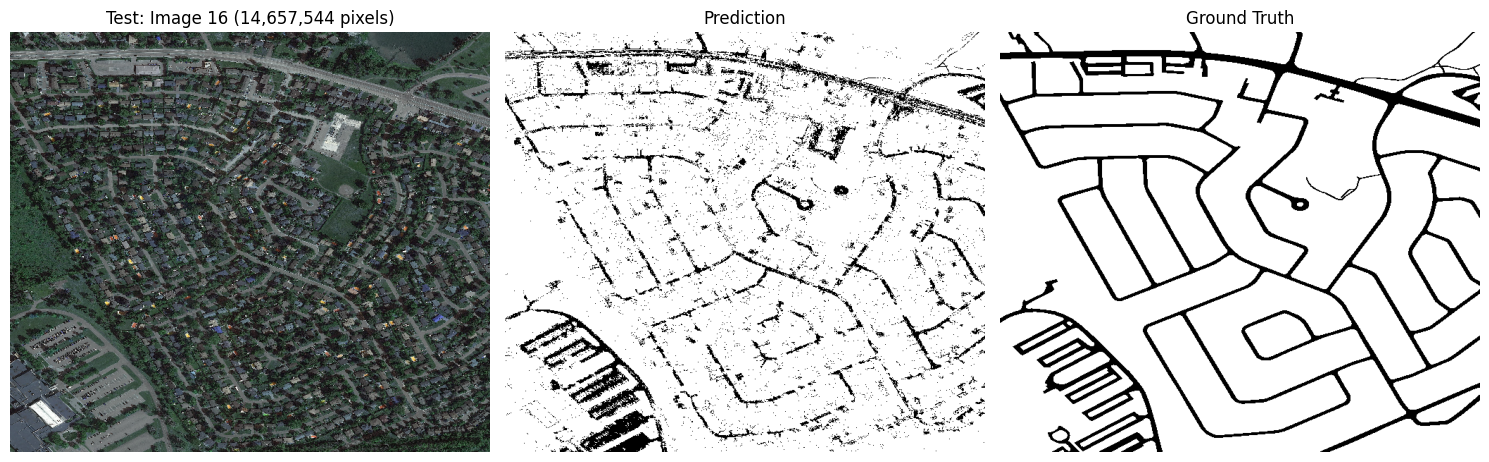

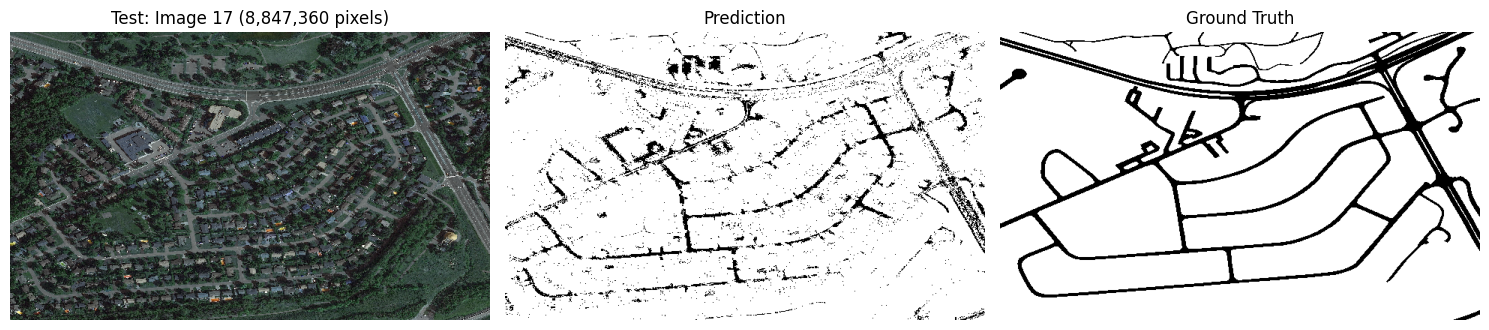

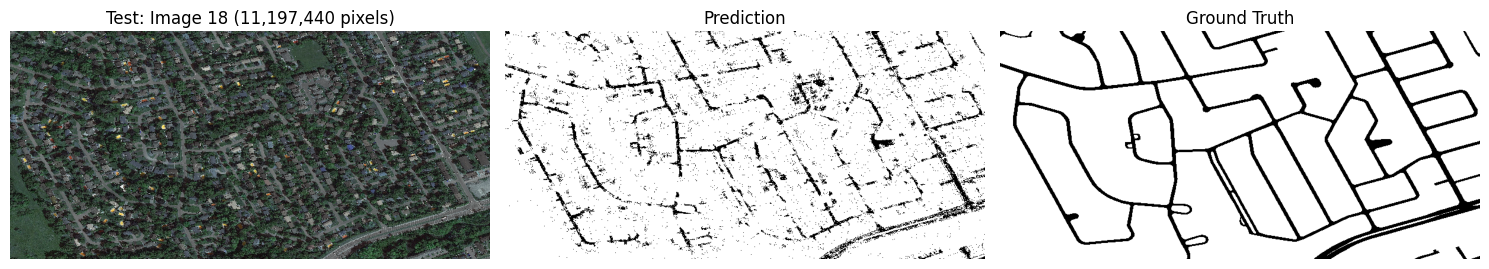

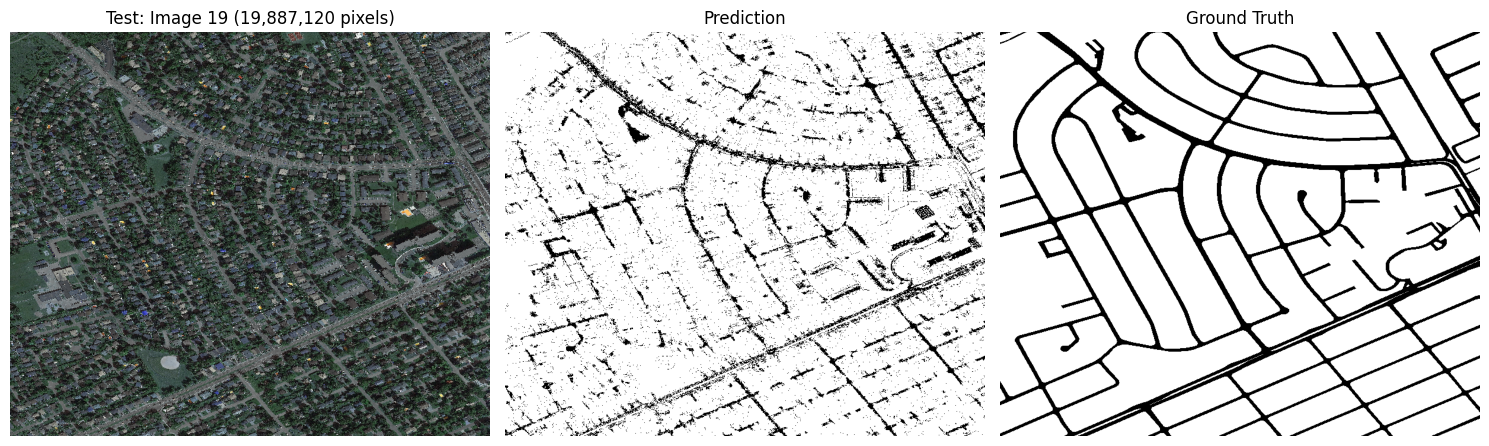

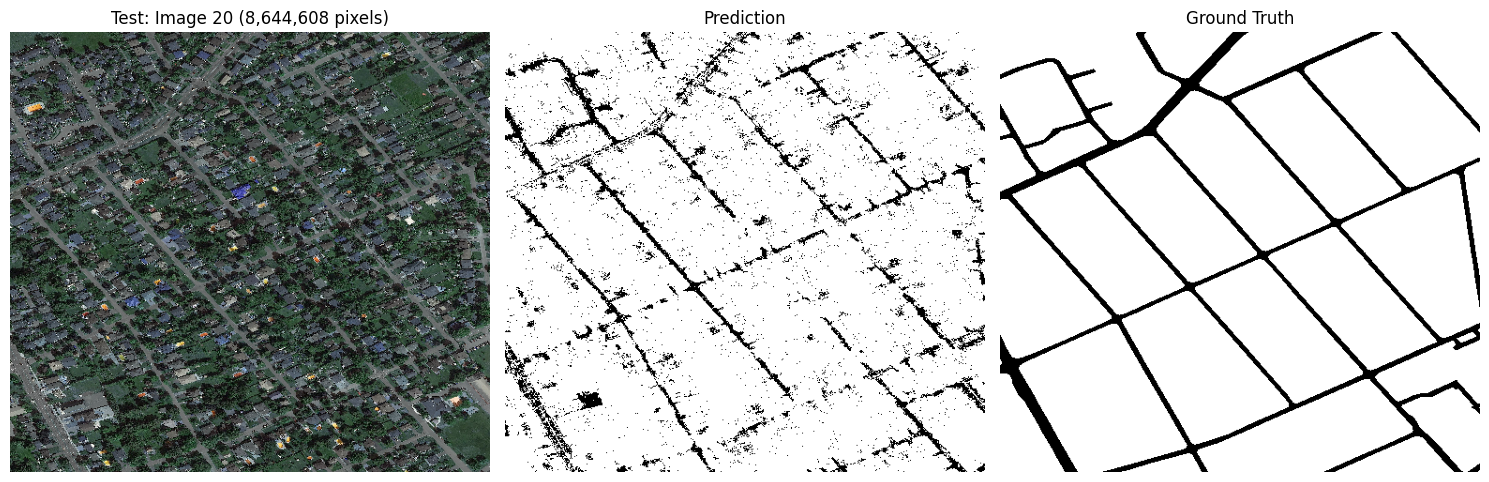

In [21]:
n_test_images = len(all_test_images)
index_start = 0

for i, path in zip(range(n_test_images), paths):
	nrow, ncol = test_shapes[i]
	n_pixels = nrow * ncol

	y_pred_i = y_pred[index_start : index_start + n_pixels]
	y_test_i = y_test[index_start : index_start + n_pixels]
	index_start += n_pixels

	y_pred_reshaped = y_pred_i.reshape(nrow, ncol)
	y_test_reshaped = y_test_i.reshape(nrow, ncol)

	arr_test_i = all_test_images[i]

	if nb_final_bands >= 3:
		bgr_test = arr_test_i[..., :3]
		rgb_test = cv2.cvtColor(bgr_test.astype(np.uint8), cv2.COLOR_BGR2RGB)
	else:
		rgb_test = arr_test_i[..., 0]
		rgb_test = ((rgb_test - rgb_test.min()) / (rgb_test.ptp() + 1e-5) * 255).astype(np.uint8)

	
	fig, axes = plt.subplots(1, 3, figsize=(15, 5))
	
	axes[0].imshow(rgb_test)
	axes[0].set_title(f"Test: Image {i+1+n_train} ({rgb_test.shape[0] * rgb_test.shape[1] * scale_factor**2:,} pixels)")
	axes[0].axis("off")

	axes[1].imshow(y_pred_reshaped, cmap='gray')
	axes[1].set_title("Prediction")
	axes[1].axis("off")
	# cv2.imwrite(path + "prediction.png", np.clip(y_pred_reshaped, 0, 255).astype(np.uint8))
	
	axes[2].imshow(y_test_reshaped, cmap='gray')
	axes[2].set_title("Ground Truth")
	axes[2].axis("off")
	
	plt.tight_layout()
	plt.show()

IoU for image 1: 0.8904
IoU for image 2: 0.8876
IoU for image 3: 0.9043
IoU for image 4: 0.8726
IoU for image 5: 0.9065
Mean IoU on the test set: 0.8923


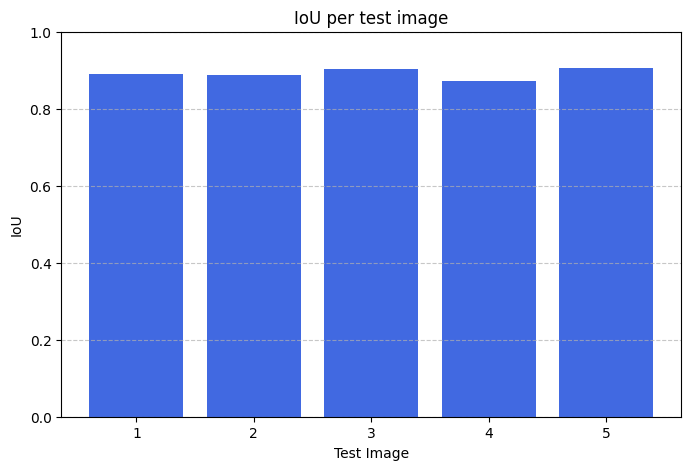

In [22]:
iou_scores = []

index_start = 0
for i in range(n_test_images):
    (nrow, ncol) = test_shapes[i]

    n_pixels = nrow * ncol
    y_pred_i = y_pred[index_start : index_start + n_pixels]
    y_test_i = y_test[index_start : index_start + n_pixels]
    index_start += n_pixels

    intersection = np.logical_and(y_test_i, y_pred_i).sum()
    union = np.logical_or(y_test_i, y_pred_i).sum()
    
    if union == 0:
        iou = 0.0
    else:
        iou = intersection / union

    iou_scores.append(iou)
    print(f"IoU for image {i+1}: {iou:.4f}")

mean_iou = np.mean(iou_scores)
print(f"Mean IoU on the test set: {mean_iou:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(range(1, n_test_images + 1), iou_scores, color="royalblue")
plt.xlabel("Test Image")
plt.ylabel("IoU")
plt.title("IoU per test image")
plt.xticks(range(1, n_test_images + 1))
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

____